In [1]:
# The file predicts the country bond ratings from indicators in CreditRatingData.ipynb.

In [2]:
import pickle

f = open('X.pckl', 'rb')
X = pickle.load(f)
f.close()

f2 = open('Y.pckl', 'rb')
Y = pickle.load(f2)
f2.close()

In [3]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf 
import tensorflow.contrib.slim as slim

imputer = preprocessing.Imputer()
transformed_X = imputer.fit_transform(X)
X_scaled = preprocessing.scale(transformed_X)

test_sizes = [519/719,419/719,319/719,219/719]
NTrials = 50
LinScores = np.zeros((np.size(test_sizes),NTrials))
LinAcc = np.zeros((np.size(test_sizes),NTrials))
SVMScores = np.zeros((np.size(test_sizes),NTrials))
SVMAcc = np.zeros((np.size(test_sizes),NTrials))
NNScores = np.zeros((np.size(test_sizes),NTrials))
NNAcc = np.zeros((np.size(test_sizes),NTrials))

for i in range(0,4):
    for j in range(0,NTrials):

        X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=test_sizes[i], random_state=j)
        
        # Linear Regression
        reg = linear_model.LinearRegression()
        reg.fit(X_train,Y_train)
        YLin = reg.predict(X_test)    
        LinScores[i,j] = metrics.r2_score(Y_test,YLin)
        LinAcc[i,j] = metrics.accuracy_score(np.round(Y_test),np.round(YLin))
        
        # Support Vector Machine
        clf = svm.SVR()
        clf.fit(X_train,Y_train)
        YSVM = clf.predict(X_test)
        SVMScores[i,j] = metrics.r2_score(Y_test,YSVM)
        SVMAcc[i,j] = metrics.accuracy_score(np.round(Y_test),np.round(YSVM))
        
        # Neural Network
        Y_train = np.reshape(Y_train,(len(Y_train),1))
        Y_test = np.reshape(Y_test,(len(Y_test),1))
        
        sess = tf.Session()

        x = tf.placeholder(dtype = tf.float32, shape = [None, np.shape(X)[1]])
        y = tf.placeholder(dtype = tf.int32, shape = [None,1])

        net = slim.stack(x, slim.fully_connected, [1000, 500, 5])

        loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y-1,5), logits=net))
        optimizer =tf.train.AdamOptimizer(0.0001)
        train_op = optimizer.minimize(loss_op)
        
        sess.run(tf.global_variables_initializer())

        for k in range(400):
            sess.run(train_op, feed_dict={x: X_train, y:Y_train})

        YNN = net.eval(feed_dict={x: X_test}, session=sess)
        NNScores[i,j] = metrics.r2_score(np.round(Y_test),np.argmax(YNN,axis=1)+1)
        NNAcc[i,j] = metrics.accuracy_score(np.round(Y_test),np.argmax(YNN,axis=1)+1)
        sess.close()
        tf.reset_default_graph()

In [4]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Accuracy scores
LinAccMean = np.mean(LinAcc, axis=1)
SVMAccMean = np.mean(SVMAcc, axis=1)
NNAccMean = np.mean(NNAcc, axis=1)

LinLearned = LinAcc[-1,:]
SVMLearned = SVMAcc[-1,:]
NNLearned = NNAcc[-1,:]
FValue, PValue = stats.f_oneway(LinLearned, SVMLearned, NNLearned)
print(PValue)

LinLabels = np.repeat(np.array('Lin'), len(LinLearned))
SVMLabels = np.repeat(np.array('SVM'), len(SVMLearned))
NNLabels = np.repeat(np.array('NN'), len(NNLearned))

DataLearned = np.hstack([LinLearned,SVMLearned,NNLearned])
LabelsLearned = np.hstack([LinLabels,SVMLabels,NNLabels])

mc = MultiComparison(DataLearned,LabelsLearned)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

4.63147246752e-53
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Lin     NN    0.1308   0.1169 0.1446  True 
 Lin    SVM    0.1182   0.1043 0.132   True 
  NN    SVM   -0.0126  -0.0264 0.0012 False 
--------------------------------------------
['Lin' 'NN' 'SVM']


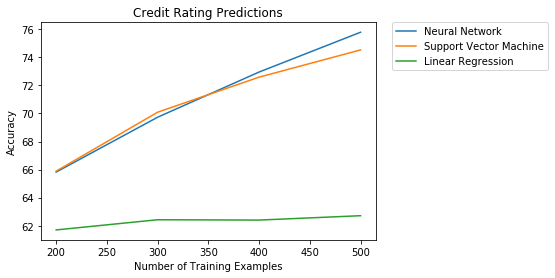

In [5]:
import matplotlib.pyplot as plt

# Credit Rating Predictions plot
TrainExam = [200,300,400,500]
plt.plot(TrainExam,NNAccMean*100,label="Neural Network")
plt.plot(TrainExam,SVMAccMean*100,label="Support Vector Machine")
plt.plot(TrainExam,LinAccMean*100,label="Linear Regression")
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Examples')
plt.title('Credit Rating Predictions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()